<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Eye_crop_bilateralEye_periocular_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・横幅を1/4倍、縦幅を上下に1/4倍追加して画像を切り取る（目の全幅、眉毛が含まれるように）

・切り取った画像を横幅640pxにresizeする<br>
・フォルダ内の画像を一括変換して別フォルダに保存

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys


import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [81]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 6.32

In [82]:
#テスト画像
test_path = '/content/drive/MyDrive/Deep_learning/Face_Images/IMG_3110.JPG'

zip_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_extended_dataset.zip'
!unzip $zip_path -d "/content"
in_path_list  = ['/content/GO_extended_dataset/Control_photo_1886mai', '/content/GO_extended_dataset/treatable']
#保存先フォルダ
out_path_list = ['/content/GO_extended_dataset/cont_for_yolo', '/content/GO_extended_dataset/grav_for_yolo']


Archive:  /content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_extended_dataset.zip
replace /content/GO_extended_dataset/Control_photo_1886mai/1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Haarcascadeを指定

In [84]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'
# righteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_righteye_2splits.xml'
# lefteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_lefteye_2splits.xml'


# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# righteye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# lefteye_cascade = cv2.CascadeClassifier(eye_cascade_path)

In [86]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 200)
    cv2_imshow(dst)

# def show_image_pillow(img):
#     src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
#     plt.imshow(src)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

def scale_to_width(img, width):
    """幅が指定した値になるように、アスペクト比を固定して、リサイズする。
    """
    h, w = img.shape[:2]
    height = round(h * (width / w))
    dst = cv2.resize(img, dsize=(width, height))

    return dst

In [88]:
def crop_bilateral(in_path, class_num, size, showImage=True):
    img_resized_list,side_list = [],[]

    img = cv2.imread(in_path) 
    img2 = img.copy()

    if showImage:
        show_image(img)

    # 画像グレースケール化
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #300pix以上のもので目に見えるものを抽出
    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
    print("")
    print('image path = ',in_path)

    # 眼検出判定
    if len(eye_list) >= 1:
        print('目が' + str(len(eye_list)) +'個検出されました')
        pass
    else:
        print("no eye detected")
        pass

    print(f"eye_list: {eye_list}")

    #画像の切り抜きと保存（連番にする）
    if len(eye_list)== 2: 

        
        for (ex, ey, ew, eh) in eye_list:
            print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
            
            try:
                cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

                #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                top = max(0, ey-int(eh/4))
                bottom = min(grayscale_img.shape[0], int(ey + eh*5/4))
                left = max(0,int(ex-int(ew/4)))
                right = min(grayscale_img.shape[1], int(ex + ew*5/4))

                #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

                img_cropped = img[top: bottom,left:right]
                height, width = img_cropped.shape[:2]

                #クロップした画像を表示
                if showImage:
                    show_image(img_cropped)
            except: 
                pass

       
        ex = min(eye_list[0][0], eye_list[1][0])
        ey = min(eye_list[0][1], eye_list[1][1])
        ew = max(eye_list[0][0]+eye_list[0][2], eye_list[1][0]+eye_list[1][2]) - ex
        eh = max(eye_list[0][1]+eye_list[0][3], eye_list[1][1]+eye_list[1][3]) - ey

        print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))

        try:
            cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

            #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
            top = max(0, int(ey-eh/4))
            bottom = min(grayscale_img.shape[0], int(ey+7/6*eh))
            left = max(0,int(ex-ew/10))
            right = min(grayscale_img.shape[1], int(ex + 11/10*ew))

            print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

            img_cropped = img[top: bottom,left:right]
            height, width = img_cropped.shape[:2]

            img_resized = scale_to_width(img_cropped, size) #1辺を指定したpixにresize 

            #クロップした画像を表示
            if showImage:
                show_image(img_resized)
            print(img2.shape)

            #縦、横に対する割合
            X = round((right+left)/2/img2.shape[1], 6)
            Y = round((top+bottom)/2/img2.shape[0], 6)
            W = round((right-left)/img.shape[1], 6)
            H = round((bottom-top)/img.shape[0], 6)
            txt = f"{class_num} {X} {Y} {W} {H}"
            return img_resized, txt

        except:
            print('crop error')


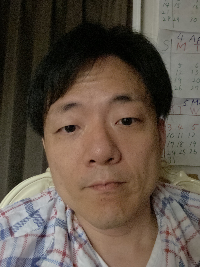


image path =  /content/drive/MyDrive/Deep_learning/Face_Images/IMG_3110.JPG
目が2個検出されました
eye_list: [[1247 1189  436  436]
 [ 596 1278  424  424]]
[ex,ey] = 1247,1189 [ew,eh] = 436,436


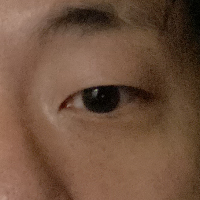

[ex,ey] = 596,1278 [ew,eh] = 424,424


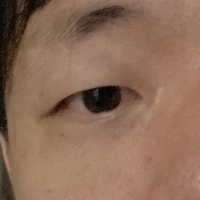

[ex,ey] = 596,1189 [ew,eh] = 1087,513
top:1060, bottom:1787, left:487, right:1791


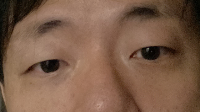

(3088, 2316, 3)
0 0.491796 0.460978 0.56304 0.235427


In [89]:
img, txt = crop_bilateral(test_path, class_num=0, size=640)
print(txt)

with open("test.txt", mode='w') as f:
    f.write(txt)


# #検出された画像を確認
# src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
# plt.imshow(src)


#**ここからがメイン**

In [90]:
orig_folder = "/content/GO_extended_dataset/Control_photo_1886mai" 
dst_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO/cont"
class_num = 1 #classをテキストに書き込む

path_list = glob.glob(orig_folder+"/*")
path = path_list[1]
path


'/content/GO_extended_dataset/Control_photo_1886mai/4223.jpg'

In [ ]:
path_list = glob.glob(orig_folder+"/*")
#path_list = [path_list[0]] #テスト用
dst_folder = dst_folder

#処理時間の計測
start = time.time()

#もしdst_folderがあれば削除して新しく作り直す
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(f"{dst_folder}/images") #image格納用
os.makedirs(f"{dst_folder}/labels") #label格納用


num=0
for path in path_list:
    try: #目が検出されなかった場合のエラー回避
        img, txt = crop_bilateral(path, class_num=class_num, size=640, showImage=True)  #両眼抜き出して640pxで保存（crop時にエラーが出るものは削除される）
        #cv2.imwrite(f"{dst_folder}/images/{os.path.basename(path).split('.')[0]}.JPG", img) #cropしたイメージを保存する場合
        shutil.copy(path, f"{dst_folder}/images/{os.path.basename(path).split('.')[0]}.JPG")
        with open(f"{dst_folder}/labels/{os.path.basename(path).split('.')[0]}.txt", mode='w') as f:
            f.write(txt)
        num+=1
    except:
        pass

print("")
print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print (f"image_num:{num}")
